<a href="https://colab.research.google.com/github/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/SentimentTestingUSDLoop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rolling LSTM testing on USD price movements

## 1 Objective and Overview

**Objective, Overview**  
A supervised learning was done to make trading decisions (Sell or Buy) for USD using USD's past price and MarketRisk TRMI. The supervised model
used was LSTM.

**Thoughts on the Results**  
The LSTM model depends on a few hyerparameters that could affect the results:
1. Train-Validate-Test Split
2. Labels
3. Features Selection
4. Number of LSTM layers and nodes

**Train-Validate-Test Split**  
The LSTM seeks to remember consistent patterns from the training set. I think the splitting of train set is important in building a good model. A long
train period may not produce better results as according to this experiment. If the dataset consist of random patterns, the LSTM model will not be able
to replicate the training result on the validate or test set as the valildate or test set differs from the train set.

**Target Labels**  
The target labels used could affect the training. If the target labels were less random to its x variables, it could help the LSTM pick up the patterns
easier. Engineering could be done to the target labels to help the training.

**Features Selection**  
Features that could predict the price movements would make the results better.

**Number of LSTM layers and nodes**  
After numerous testing, a 2 layer LSTM, each with 20 nodes would allow the model to converge if the model is able to converge.




## 1.1 Splitting Train-Validate-Test Set

2007-01-01 data to 2018-12-31 USD price and TRMI MarketRisk data was used for this experiment.

The data is split to train-validate-test set as below:

![alt text](10 year train test split.JPG)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


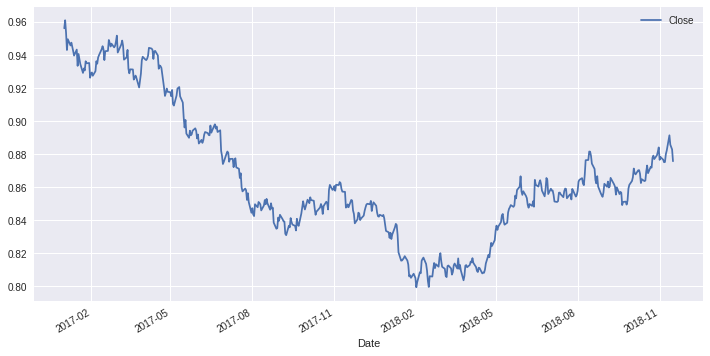

In [51]:
# Plotting USD prices
ax = tradeTable["2017-01-01":"2018-12-31"].plot(y=['Close'], figsize=(12,6), grid=True)

## 1.2 Feature Engineering

![alt text](https://github.com/hugegene/LSTM-Prediction-of-Stock-Price-Movement/blob/master/USDprice.png?raw=1)

USD price was overlayed with various TRMIs moving averages and the 30-days MarketRisk moving average seems to co-related well with the price visually. As such, the following was feature-enginnered as the input to the LSTM model for all the experiments:

1. MarketRisk
2. 7-day MarketRisk moving-average
3. 30-day MarketRisk moving-average
4. 90-day MarketRisk moving-average
5. Returns from previous day Close (r1)
6. Returns from previous 7th day Close (r2)
7. Returns from previous 30th day Close (r3)
8. Returns from previous 90th day Close (r4)

## 1.3 Evaluation Metrics

The evaluation metrics are:
1. Matthews correlation coefficient (MCC)
2. Accuracy
3. Profit and Loss


## 1.4 Labels

Each timestep is labelled Sell(0) or Buy(1) depending on whether the next closing price is up or down.


## 1.5 LSTM Set-Up

The LSTM is set-up to predict the labels based on the sequential data of the past 5 time-steps.


## 1.6 Trading

Each LSTM prediction of Buy will result in a buying and holding of USD for 1 day  and each LSTM prediction of Sell will result in a short-sell and holding of USD for 1 day.

## 2 Results 

In [0]:
EFF_TEST_START
EFF_TEST_END

In [5]:
# calculating cumulative predicted and labelled trade returns over each time step
PNLTable =  tradeTable.loc[EFF_TEST_START:EFF_TEST_END,:].copy()
PNLTable["labelledPNL"] =  (1+PNLTable['labelledreturns']).cumprod()
PNLTable["PNL"] = (1+PNLTable['predictedreturns']).cumprod()
PNLTable.head()

#plotting Confusion Matrix
f = plt.figure(figsize=(15,7))
ax = f.add_subplot(131)
plotConfusion(EFF_TEST_START, EFF_TEST_END, "")

f = plt.figure(figsize=(36,6))
ax = f.add_subplot(131)

# PNL Plot for the Test Period
PNLTable["PNL"].plot()

NameError: ignored

## 2.1 Evaluation

The model overfit the validation set right from the start, making any improvement on the train set worse on the validation set. The most accurate model validated by the validation set predicts all Buy for the test period (as shown in the confusion matrix), making it not a good model.

##  3 Codes

In [2]:
from google.colab import files
uploaded = files.upload()

Saving USDprices.csv to USDprices.csv
Saving USDSentiment.csv to USDSentiment.csv


In [6]:
!ls

sample_data  USDprices.csv  USDSentiment.csv


In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from datetime import datetime
import os
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.layers import Input, LSTM, RepeatVector, Lambda, Dense, Flatten, Permute, merge, multiply
from keras.models import Model
from keras import backend as K
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score as areauc
import tensorflow as tf
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

Using TensorFlow backend.


## 3.1 Data Preparation

In [8]:
##Read in Price data, use date as index
Prices = pd.read_csv("USDprices.csv")
Prices.head()
Prices['Date'].dtype
Prices['Date'] = pd.to_datetime(Prices['Date'], format='%Y-%m-%d')
Prices.head()
Prices.index = Prices['Date']
# print(Prices.head())

#Reading in Sentiment Data and selecting News-only-MarketRisk Sentiment
Sent = pd.read_csv("USDSentiment.csv")
Sent = Sent[Sent.dataType=='News'][['Date', 'marketRisk']].fillna(method = "ffill")
# Sent.head()
Sent['Date'] = pd.to_datetime(Sent['Date'], format='%Y-%m-%d')
Sent.index = Sent['Date']
# print(Sent.head())

#Combining Price table and Sentiment Table
Ana = Prices.merge(Sent, left_index= True, right_index=True, how='inner')
Ana.head()
Ana.columns
Ana = Ana.drop(columns=['Unnamed: 0', 'Volume', 'Asset', 'Date_x', 'Date_y', 'Open', 'High', 'Low', 'UnadjClose'])
Ana.head()

# calculating r, %tage change of closing price over previous time step
Ana['returns'] = (Ana['Close']- Ana['Close'].shift(1))/Ana['Close'].shift(1)
Ana.head()

# calculating target price
Ana['Target'] = Ana["Close"].diff(1).shift(-1)
Ana.head()

# calculating %change
Ana['Change'] = Ana["returns"].shift(-1)
Ana.head()


## Label each time step False(no-buy) or True(buy) based on whether the price will rise at the next closing price
timestep = 1
labels = []
for i in range(0, Ana.shape[0]):
  if(i+timestep< Ana.shape[0]):
    aheadGain = [Ana["returns"][i+j] for j in range(1,timestep+1)]
    labels+= [np.sum(aheadGain)> 0]

print(len(labels))

# Price Table with Labels as Signal
Ana = Ana.iloc[:-timestep,:].copy()
Ana.head()
Ana['Signal'] = labels
Ana.head()

#Feature Engineering
Ana["Close30"] =  Ana["Close"].rolling(30).mean()
Ana["Close100"] =  Ana["Close"].rolling(100).mean()
Ana["r1"] =  Ana["Close"].diff(1)
Ana["r2"] =  Ana["Close"].diff(7)
Ana["r3"] =  Ana["Close"].diff(30)
Ana["r4"] =  Ana["Close"].diff(90)
Ana["marketrisk_avg30"] = Ana["marketRisk"].rolling(30).mean()
Ana["marketrisk_avg90"] = Ana["marketRisk"].rolling(90).mean()
Ana["marketrisk_avg7"] = Ana["marketRisk"].rolling(7).mean()

#Drop NA
Ana = Ana.dropna(0)
Ana.head()

5448


,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,r3,r4,marketrisk_avg30,marketrisk_avg90,marketrisk_avg7
Date,,,,,,,,,,,,,,,
1998-05-21,0.894694,0.017921,-0.005816,-0.001439,-0.001608,False,0.905687,0.916241,-0.005234,-0.007833,-0.025692,-0.031832,0.030184,0.034995,0.031504
1998-05-22,0.893256,0.054887,-0.001608,0.004813,0.005388,True,0.904816,0.916045,-0.001439,-0.011721,-0.026115,-0.034474,0.030500,0.035283,0.035738
1998-05-25,0.898069,0.072076,0.005388,0.001373,0.001529,True,0.904089,0.915792,0.004813,-0.005518,-0.021809,-0.030695,0.031202,0.035543,0.042474
1998-05-26,0.899442,0.120229,0.001529,0.006027,0.006700,True,0.903746,0.915530,0.001373,-0.007587,-0.010310,-0.030358,0.034618,0.036311,0.056034
1998-05-27,0.905469,0.057863,0.006700,-0.001718,-0.001898,False,0.903617,0.915352,0.006027,-0.001643,-0.003870,-0.016785,0.036330,0.036533,0.055463


In [9]:
#Define function to convert dataframe to training, validating and testing examples
def series_to_supervised(df, n_in=1, n_out=1):
	n_vars = 1 if type(df) is list else df.shape[1]
  
  
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, -1, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]

	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	return agg

#Features Selection
Set =  Ana[['r1', 'r2', 'r3','r4', 'marketRisk', 'marketrisk_avg7', 'marketrisk_avg30', 'marketrisk_avg90']]
# Set =  Ana[['r1', 'r2']]
FEATURES_SHAPE =  Set.shape[1]
print(FEATURES_SHAPE)

#Forming examples
SEQ_LEN = 5
Set =  series_to_supervised(Set, SEQ_LEN-1, 0)
Set[["Change", "Signal"]] = Ana[["Change", "Signal"]]
Set = Set.dropna()
print(Set.shape)
# Set.head()

8
(5345, 42)


In [0]:
#Remove bad training and validating examples
SetAdjusted = Set.copy()
# SetAdjusted = Set.loc[(Set.Change< -0.0015)| (Set.Change> 0.003)]
# SetAdjusted.head()

## 3.2 Train-Validate-Test Split

In [46]:
daterange = pd.date_range(start='18/1/2017', periods=2, freq='2W')

print(daterange)
print(daterange[0].strftime("%Y-%m-%d"))
len(daterange)

for single_date in daterange:
  print(single_date - relativedelta(years=1))

DatetimeIndex(['2017-01-22', '2017-02-05'], dtype='datetime64[ns]', freq='2W-SUN')
2017-01-22
2016-01-22 00:00:00
2016-02-05 00:00:00


In [9]:
testyhat = []
testyhat += [[1,2,3]]
testyhat += [[1,2,3]]
testyhat
np.mean(testyhat, axis =0) > 1

array([False,  True,  True])

In [96]:
daterange = pd.date_range(start='1/1/2017', periods=1 , freq='4W')
print(daterange)
tradeTable= Ana.copy()
tradeTable["predictSignal"] = 0
# tradeTable.head()
EFF_TEST_START = ""
EFF_TEST_END = ""
num = 0 
ENSEMBLE = 1

for single_date in daterange:
  
  testyhat = []
  num += 1
      
  for i in range(0, ENSEMBLE):
    TRAIN_START = (single_date - relativedelta(years = 10)).strftime("%Y-%m-%d")
    TRAIN_END = (single_date - relativedelta(years =2) - timedelta(days=1)).strftime("%Y-%m-%d") 
    
    VAL_START = (single_date - relativedelta(years = 2)).strftime("%Y-%m-%d")
    VAL_END = (single_date - timedelta(days = 1)).strftime("%Y-%m-%d")
    
    TEST_START = (single_date).strftime("%Y-%m-%d")
    TEST_END = (single_date + relativedelta(years=2)).strftime("%Y-%m-%d")
    print(TRAIN_START)
    print(TRAIN_END)
    print(VAL_START)
    print(VAL_END)
    print(TEST_START)
    print(TEST_END)
  
    if num == 1:
      EFF_TEST_START = TEST_START
    if num == len(daterange):
      EFF_TEST_END = TEST_END
    

    #Set x and y variables
    FIRSTTRAINVAR = SetAdjusted.columns[0]
    print(FIRSTTRAINVAR)
    LASTTRAINVARIABLE = SetAdjusted.columns[-3]
    print(LASTTRAINVARIABLE)
    YVAR= "Signal"

  #   #Split train and test set at TRAIN_DATE_END and TEST_DATE_START
  #   TRAIN_START = "2017-01-01"
  #   TRAIN_END = "2017-03-31"
  #   # VALIDATE_START = "2018-01-01"
  #   # VALIDATE_END = "2018-05-31"
  #   TEST_START = "2017-01-01"
  #   TEST_END = "2017-04-30"

    #Specify LSTM input shape
    X_SHAPE1 = 5
    X_SHAPE2 = FEATURES_SHAPE

    #train_x
    train_x = SetAdjusted.loc[TRAIN_START:TRAIN_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
    # Normalised train_x to [0,1]
    # print(train_x.head())
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_x = scaler.fit_transform(train_x)
  #   print(train_x.shape)
    #reshape train_x for RNN input
    train_x = train_x.reshape(train_x.shape[0], X_SHAPE1, X_SHAPE2)
  #   print(train_x.shape)

    #train_y
    train_y = SetAdjusted.loc[TRAIN_START:TRAIN_END, YVAR]
    train_y = train_y.values.reshape((train_y.shape[0], 1))
    yscaler = MinMaxScaler(feature_range=(0, 1))
    # train_y = yscaler.fit_transform(train_y)
  #   print(train_y.shape)
  
    #val_x
    val_x = Set.loc[VAL_START:VAL_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
    # Normalised val_x to [0,1]
    val_x = scaler.transform(val_x)
    #reshape val_x for RNN input
    val_x = val_x.reshape(val_x.shape[0], X_SHAPE1, X_SHAPE2)
  #   print(test_x.shape)

    #val_y
    val_y = Set.loc[VAL_START:VAL_END, YVAR]
    val_y = val_y.values.reshape((val_y.shape[0], 1))
    # test_y = yscaler.transform(test_y)

    #test_x
    test_x = Set.loc[TEST_START:TEST_END, FIRSTTRAINVAR:LASTTRAINVARIABLE]
    # Normalised train_x to [0,1]
    test_x = scaler.transform(test_x)
    #reshape test_x for RNN input
    test_x = test_x.reshape(test_x.shape[0], X_SHAPE1, X_SHAPE2)
  #   print(test_x.shape)

    #test_y
    test_y = Set.loc[TEST_START:TEST_END, YVAR]
    test_y = test_y.values.reshape((test_y.shape[0], 1))
    # test_y = yscaler.transform(test_y)

  #   print(test_y.shape)


    TESTEND = test_x.shape[0]
    # TESTSTART = train_x.shape[0] + validate_x.shape[0]
    TESTSTART = train_x.shape[0]
    # VALIDATESTART = train_x.shape[0]
    print(TESTSTART)

    ## Specifying Batch Size
    n_batch = 2

    ## Only to use when removing model 
    !rm best.h5

    #Check train_y statistic
    trainStats = np.unique(train_y, return_counts=True)
    print(trainStats)

    #Set Classweight
    if trainStats[1][0] > trainStats[1][1]: 
      classweight = {0:1, 1:trainStats[1][0]/trainStats[1][1]}
    else:
      classweight = {0:trainStats[1][1]/trainStats[1][0], 1:1}

    print(classweight)

    units = 20
    inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
    secondary = LSTM(units, return_sequences=True)(inputs)
    activations = LSTM(units, return_sequences=True)(secondary)
    # out = Dense(1, activation='sigmoid')(activations)

    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units)(attention)
    attention = Permute([2, 1])(attention)


    sent_representation = multiply([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

    probabilities = Dense(1, activation='sigmoid')(sent_representation)


    model = Model(inputs=inputs, outputs=probabilities)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=["binary_accuracy"])

    # Checkpoint
    checkpoint = ModelCheckpoint("best.h5", monitor='val_binary_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    early = EarlyStopping(monitor='val_binary_accuracy', min_delta=0, patience=40, verbose=0, mode='auto')
    callbacks_list = [checkpoint]

    # Fit model
    if os.path.isfile("best.h5"):
      model.load_weights("best.h5")

    history = model.fit(train_x, train_y, epochs=3,  batch_size=n_batch, callbacks=[checkpoint, early],
                        validation_data=(val_x, val_y), 
                        shuffle=False, verbose =  1,
                          class_weight= classweight
                          )

    # Make predictions, yhat, on test set
    if os.path.isfile("best.h5"):
      model.load_weights("best.h5")
    yhat = model.predict(test_x, batch_size=n_batch)
    # yhat = yscaler.inverse_transform(yhat)
    print(test_x.shape)
    print(yhat.shape)

    ## Reading yhat as predictSignal
    testyhat += [yhat]
    print(len(testyhat))
    
    print(tradeTable.loc[TEST_START:TEST_END, "predictSignal"].shape)
    tradeTable.loc[TEST_START:TEST_END, "predictSignal"] = np.mean(testyhat, axis =0) >0.5
    
    # tradeTable["predictPrice"] = yhat
    # tradeTable["predictSignal"]= tradeTable["predictPrice"]>0
  #   tradeTable.head()
  
  

#Changing Signals to Weights
tradeTable['predictedweight'] = np.where(tradeTable['predictSignal'] == True, 1, -1)
tradeTable['labelledweight'] = np.where(tradeTable['Signal'] == True, 1, -1)
tradeTable.head()

# calculating r, %tage change of closing price over previous time step
tradeTable['r'] = (tradeTable['Close']- tradeTable['Close'].shift(1))/tradeTable['Close'].shift(1)
tradeTable.head()

# calculating predicted and labelled trade returns over each time step
tradeTable['predictedreturns'] = tradeTable['r']*tradeTable['predictedweight'].shift(1)
tradeTable['labelledreturns'] = tradeTable['r']*tradeTable['labelledweight'].shift(1)

tradeTable

DatetimeIndex(['2017-01-01'], dtype='datetime64[ns]', freq='4W-SUN')
2007-01-01
2014-12-31
2015-01-01
2016-12-31
2017-01-01
2019-01-01
r1(t-4)
marketrisk_avg90(t-0)
2088
(array([False,  True]), array([1073, 1015]))
{0: 1, 1: 1.0571428571428572}
Train on 2088 samples, validate on 522 samples
Epoch 1/3
2088/2088 [==============================] - 50s 24ms/step - loss: 0.7136 - binary_accuracy: 0.5043 - val_loss: 0.6926 - val_binary_accuracy: 0.5192

Epoch 00001: val_binary_accuracy improved from -inf to 0.51916, saving model to best.h5
Epoch 2/3
2088/2088 [==============================] - 33s 16ms/step - loss: 0.7134 - binary_accuracy: 0.5000 - val_loss: 0.6926 - val_binary_accuracy: 0.5192

Epoch 00002: val_binary_accuracy did not improve from 0.51916
Epoch 3/3
2088/2088 [==============================] - 33s 16ms/step - loss: 0.7132 - binary_accuracy: 0.4990 - val_loss: 0.6926 - val_binary_accuracy: 0.5192

Epoch 00003: val_binary_accuracy did not improve from 0.51916
(495, 5, 8)
(495

,Close,marketRisk,returns,Target,Change,Signal,Close30,Close100,r1,r2,...,r4,marketrisk_avg30,marketrisk_avg90,marketrisk_avg7,predictSignal,predictedweight,labelledweight,r,predictedreturns,labelledreturns
Date,,,,,,,,,,,,,,,,,,,,,
1998-05-21,0.894694,0.017921,-0.005816,-0.001439,-0.001608,False,0.905687,0.916241,-0.005234,-0.007833,...,-0.031832,0.030184,0.034995,0.031504,0,-1,-1,NaN,NaN,NaN
1998-05-22,0.893256,0.054887,-0.001608,0.004813,0.005388,True,0.904816,0.916045,-0.001439,-0.011721,...,-0.034474,0.030500,0.035283,0.035738,0,-1,1,-0.001608,0.001608,0.001608
1998-05-25,0.898069,0.072076,0.005388,0.001373,0.001529,True,0.904089,0.915792,0.004813,-0.005518,...,-0.030695,0.031202,0.035543,0.042474,0,-1,1,0.005388,-0.005388,0.005388
1998-05-26,0.899442,0.120229,0.001529,0.006027,0.006700,True,0.903746,0.915530,0.001373,-0.007587,...,-0.030358,0.034618,0.036311,0.056034,0,-1,1,0.001529,-0.001529,0.001529
1998-05-27,0.905469,0.057863,0.006700,-0.001718,-0.001898,False,0.903617,0.915352,0.006027,-0.001643,...,-0.016785,0.036330,0.036533,0.055463,0,-1,-1,0.006700,-0.006700,0.006700
1998-05-28,0.903751,0.039126,-0.001898,0.003361,0.003719,True,0.903403,0.915163,-0.001718,-0.001882,...,-0.011916,0.035828,0.036895,0.055423,0,-1,1,-0.001898,0.001898,0.001898
1998-05-29,0.907112,0.044906,0.003719,-0.004096,-0.004515,False,0.903251,0.915000,0.003361,0.007184,...,0.004422,0.036237,0.037338,0.058144,0,-1,-1,0.003719,-0.003719,0.003719
1998-06-01,0.903016,0.082701,-0.004515,0.000734,0.000813,True,0.903043,0.914801,-0.004096,0.008322,...,-0.007233,0.038099,0.037892,0.067398,0,-1,1,-0.004515,0.004515,0.004515
1998-06-02,0.903751,0.031756,0.000813,-0.005278,-0.005840,False,0.902986,0.914626,0.000734,0.010495,...,-0.003938,0.038561,0.038163,0.064094,0,-1,-1,0.000813,-0.000813,0.000813


In [0]:
# define confusion matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize= (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plotConfusion(start, end, string):
  real = tradeTable["labelledweight"]
  pred = tradeTable["predictedweight"]
  cnf_matrix = confusion_matrix(real[start:end], pred[start:end])
  accuracy = np.around(accuracy_score(real[start:end], pred[start:end]),2)
  f1= np.around(f1_score(real[start:end], pred[start:end], average='binary'), 2)
  auc = np.around(areauc(real[start:end], pred[start:end]), 2)
  prec = np.around(precision_score(real[start:end], pred[start:end], average='binary'), 2)
  recall = np.around(recall_score(real[start:end], pred[start:end], average='binary'), 2)
  mcc =  np.around(matthews_corrcoef(real[start:end], pred[start:end]), 2)
  # np.set_printoptions(precision=2)


  plot_confusion_matrix(cnf_matrix, classes=['Sell', 'buy'],
                        title=string + ' Accuracy: ' +str(accuracy)
                        + ', AUC:' + str(auc)
#                         + ', F1 Score:' + str(f1)
#                         + ', Precison:' + str(prec)
#                         + ', Recall:' + str(recall)
                        + ', MCC:' + str(mcc))